In [70]:
import os, sys, json
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from collections import defaultdict
from tabulate import tabulate
from IPython.core.display import display, HTML

# Increase display width
display(HTML("<style>.container { width:80% !important; }</style>"))

# Some styling
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline
# plt.rcParams['figure.figsize'] = 10, 10

In [71]:
# We reuse these over and over and it's easier to have them in a list than unordered dict
model_names = ["wgan", "wgpgan", "nsgan", "mmgan", "ragan", 
               "lsgan", "dragan", "began", "infogan", "fishergan", 
               "fgan_forward_kl", "fgan_reverse_kl", "fgan_jensen_shannon",
               "fgan_total_var", "fgan_hellinger", "fgan_pearson"]
plot_names = ['WGAN', 'WGANGP', 'NSGAN', 'MMGAN', 'RAGAN', 'LSGAN', 'DRAGAN', 'BEGAN', 'InfoGAN',
              'FisherGAN','ForwGAN', 'RevGAN', 'JSGAN', 'TVGAN', 'HellingerGAN', 'PearsonGAN', 'Expected']
distance_metrics=["KL-Divergence", "Jensen-Shannon", "Wasserstein-Distance"]#, "Energy-Distance"]
title_names=["Kullback-Leibler Divergence", "Jensen-Shannon Divergence", "Wasserstein Distance"]

# Colors
palette = ["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a", "#d62728", "#ff9896", "#9467bd",
            "#c5b0d5", "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", "#c7c7c7", "#bcbd22" "#dbdb8d",
            "#17becf", "#9edae5"]


def graph_mnist(optimal, 
               ci=True,
               omit_outliers=True,
               thresh=8.5,
               save=False,
               model_names=model_names,
               distance_metrics=distance_metrics,
               palette=palette):
    
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(20,10))
    
    for d_idx, metric in enumerate(distance_metrics):
            
        max_upper = 0

        for idx, model_name in enumerate(model_names):

            if model_name in ['vae', 'autoencoder']:
                continue

            data = optimal[model_name]['mnist'][metric]['mean']

            if omit_outliers:
                
                # Remove outliers
                orig_data = np.array(data)
                notnan_indexes = ~np.isnan(orig_data)
                outlier_indexes = is_outlier(orig_data[notnan_indexes], thresh=thresh)
                data = orig_data.flatten()[~outlier_indexes]

                x = np.linspace(0, orig_data.shape[0], data.shape[0])
                high = data + np.array(optimal[model_name]['mnist'][metric]['h']).flatten()[~outlier_indexes]
                low = data - np.array(optimal[model_name]['mnist'][metric]['h']).flatten()[~outlier_indexes]

            else:

                x = range(0, len(data))
                high = data + np.array(optimal[model_name]['mnist'][metric]['h'])
                low = data - np.array(optimal[model_name]['mnist'][metric]['h'])

            axes[d_idx].plot(x,
                            data,
                            label=plot_names[idx],
                            c=palette[idx])

            if ci == True:
                maxi = max(data) + (0.10*max(data))
                if maxi > max_upper:
                    max_upper = maxi
                axes[d_idx].fill_between(x,
                                        high,
                                        [max(0, i) for i in low],
                                        facecolor=palette[idx],
                                        alpha=0.3)
                
        axes[d_idx].grid(alpha=0.3)
        axes[d_idx].set_xlim(0, 25)
        axes[d_idx].set_ylim(top=max_upper)
        axes[d_idx].set_title("{0}".format(title_names[d_idx]), fontsize=18)

    fig.suptitle("{0}".format('Autoencoded MNIST'), x=0.5, y=0.95, fontsize=20)
    fig.text(0.5, 0.07, "Epoch", ha='center', fontsize=18)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
#     if save == True:
#         plt.savefig('../graphs/multivariate/{0}_{1}_{2}.png'.format(metric, dims, samples), 
#                     dpi=100, bbox_inches='tight')

    plt.show()

            
def mean_confidence_interval(data, axis=0, confidence=0.95):
#     try:
    n = data.shape[axis]
#     except IndexError:
#         axis = 0
#         n = data.shape[axis]

    mu, std = np.nanmean(data, axis=axis), scipy.stats.sem(data, axis=axis, nan_policy='omit')
    h = np.ma.getdata(std) * scipy.stats.t.ppf((1 + confidence) / 2., n-1)       

    return mu, h, mu-h, mu+h


def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


def nested_pickle_dict():
    """ Picklable defaultdict nested dictionaries """
    return defaultdict(nested_pickle_dict)


def load_best(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
        
    return data

In [72]:
optimal = load_best('/Users/sob/Desktop/gan_results/best_1024/mnist/0_dims_0_samples/data.json')

In [73]:
print(tabulate([[plot_names[idx], optimal[key]['mnist']['KL-Divergence']['parameters'][:2], optimal[key]['mnist']['Jensen-Shannon']['parameters'][:2], optimal[key]['mnist']['Wasserstein-Distance']['parameters'][:2]]
                for idx, key in enumerate(model_names)], 
               headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma'], tablefmt='latex'), '\n')

\begin{tabular}{llll}
\hline
 Model        & Normal         & Beta           & Gumbel         \\
\hline
 WGAN         & [0.0025, 512]  & [0.025, 32]    & [0.00025, 128] \\
 WGANGP       & [0.025, 512]   & [0.0025, 512]  & [0.00025, 128] \\
 NSGAN        & [0.0025, 512]  & [0.0025, 128]  & [0.00025, 512] \\
 MMGAN        & [0.0025, 64]   & [0.0025, 64]   & [0.00025, 128] \\
 RAGAN        & [0.0025, 128]  & [0.0025, 128]  & [0.00025, 512] \\
 LSGAN        & [0.0025, 64]   & [0.0025, 64]   & [0.00025, 128] \\
 DRAGAN       & [0.0025, 512]  & [0.0025, 512]  & [0.00025, 128] \\
 BEGAN        & [0.025, 32]    & [0.025, 32]    & [0.00025, 256] \\
 InfoGAN      & [0.0025, 32]   & [0.0025, 128]  & [0.00025, 512] \\
 FisherGAN    & [0.0025, 128]  & [0.0025, 128]  & [0.00025, 128] \\
 ForwGAN      & [0.0025, 32]   & [0.0025, 32]   & [0.00025, 128] \\
 RevGAN       & [0.0025, 64]   & [0.0025, 64]   & [0.00025, 128] \\
 JSGAN        & [0.0025, 128]  & [0.0025, 128]  & [0.00025, 128] \\
 TVGAN      

 Plot mean performance across epochs for MNIST 


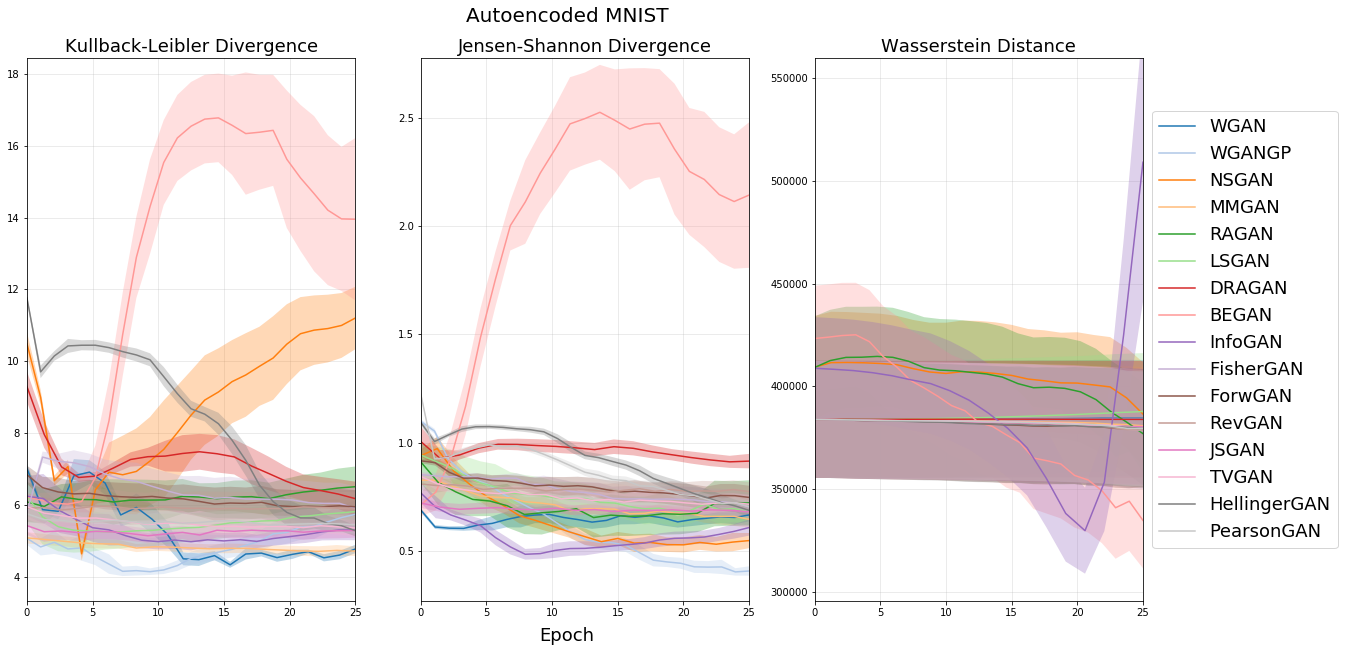

In [74]:
print(""" Plot mean performance across epochs for MNIST """)
graph_mnist(optimal, ci=True, omit_outliers=True, save=True, thresh=3.0)

In [75]:
print(""" Print confidence intervals for minimum across all runs\n """)
rankings_dict = nested_pickle_dict()
param_dict = nested_pickle_dict()

for metric in distance_metrics:

    for model_name in model_names:

        minimums = np.nanmin(np.array(optimal[model_name]['mnist'][metric]['values']), axis=1)
        mu, h, low, high = mean_confidence_interval(minimums)
        param_dict[metric][model_name]['mnist'] = '%.3f ± %.3f' % (np.round(mu, 3), np.round(h, 3))

data = [[plot_names[idx], param_dict['KL-Divergence'][key]['mnist'], param_dict['Jensen-Shannon'][key]['mnist'],
              param_dict['Wasserstein-Distance'][key]['mnist']]
         for idx, key in enumerate(model_names)]
print(tabulate(data, headers=['Model', 'KL-Divergence', 'Jensen-Shannon', 'Wasserstein-Distance'], tablefmt='latex'), '\n')

rankings = np.argsort([[eval(i[:4]) if i[:4] != 'nan ' else 1e10 for i in j[1:]] for j in data], axis=0)

 Print confidence intervals for minimum across all runs
 
\begin{tabular}{llll}
\hline
 Model        & KL-Divergence   & Jensen-Shannon   & Wasserstein-Distance   \\
\hline
 WGAN         & 4.259 ± 0.077   & 0.571 ± 0.012    & 383969.779 ± 28412.789 \\
 WGANGP       & 3.974 ± 0.046   & 0.376 ± 0.012    & 383937.132 ± 28404.833 \\
 NSGAN        & 4.553 ± 0.149   & 0.458 ± 0.023    & 338329.023 ± 23046.263 \\
 MMGAN        & 4.576 ± 0.123   & 0.601 ± 0.026    & 378646.887 ± 28229.324 \\
 RAGAN        & 4.922 ± 0.441   & 0.566 ± 0.081    & 345278.656 ± 26385.917 \\
 LSGAN        & 4.786 ± 0.373   & 0.618 ± 0.061    & 383927.964 ± 28405.458 \\
 DRAGAN       & 5.764 ± 0.298   & 0.868 ± 0.014    & 383941.206 ± 28401.277 \\
 BEGAN        & 5.696 ± 0.131   & 0.656 ± 0.016    & 329226.845 ± 22994.411 \\
 InfoGAN      & 4.696 ± 0.214   & 0.444 ± 0.012    & 324175.002 ± 22242.122 \\
 FisherGAN    & 5.159 ± 0.291   & 0.687 ± 0.061    & 375998.978 ± 28413.690 \\
 ForwGAN      & 5.718 ± 0.476   & 0.7

In [79]:
print(""" Get relative ranking performance based on mean minimum performance\n """)
print('0 is the best performance.\n')

print(tabulate([[plot_names[idx], rankings[idx, 0], rankings[idx, 1], rankings[idx, 2]]
                 for idx, key in enumerate(model_names)], 
               headers=['Model', 'KL-Divergence', 'Jensen-Shannon', 'Wasserstein-Distance'], tablefmt='latex'))

 Get relative ranking performance based on mean minimum performance
 
0 is the best performance.

\begin{tabular}{lrrr}
\hline
 Model        &   KL-Divergence &   Jensen-Shannon &   Wasserstein-Distance \\
\hline
 WGAN         &               1 &                1 &                      8 \\
 WGANGP       &               0 &                8 &                      7 \\
 NSGAN        &               2 &                2 &                      2 \\
 MMGAN        &               3 &                4 &                      4 \\
 RAGAN        &               8 &                0 &                     11 \\
 LSGAN        &              12 &                3 &                     13 \\
 DRAGAN       &               5 &                5 &                      9 \\
 BEGAN        &               4 &                7 &                     15 \\
 InfoGAN      &              14 &               12 &                     10 \\
 FisherGAN    &              13 &                9 &                      3 

 Plot mean minimum performance with error bars as a function of number samples 


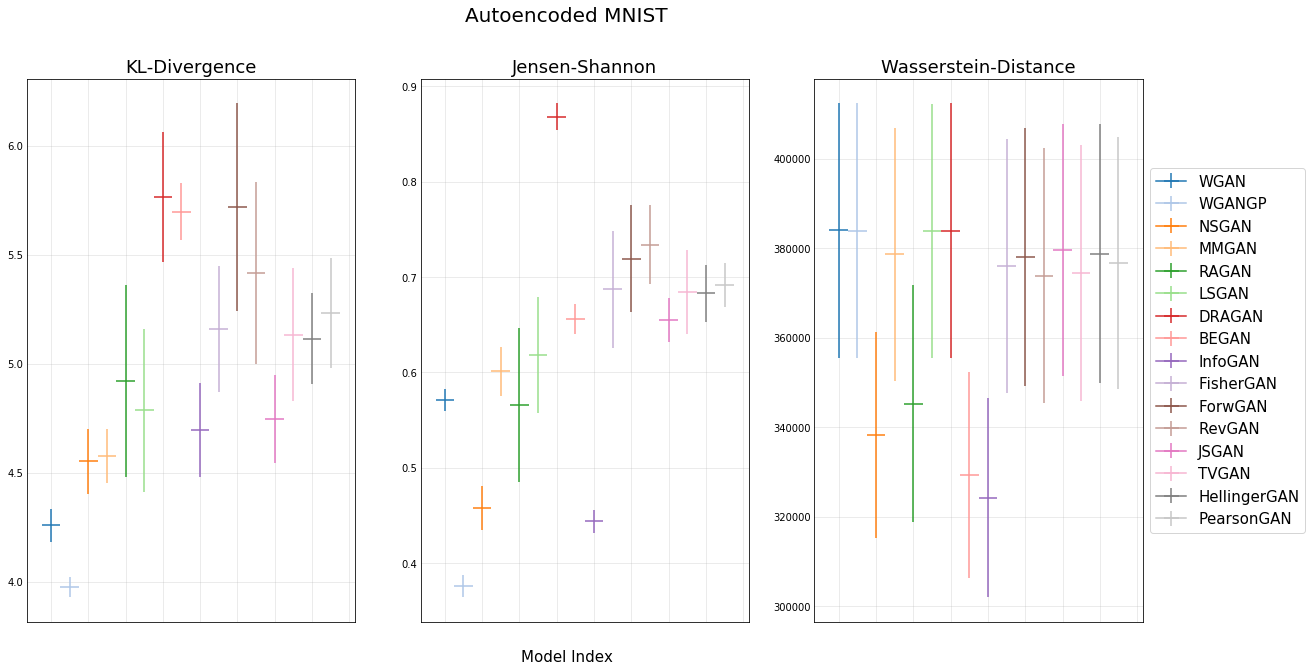

In [68]:
print(""" Plot mean minimum performance with error bars as a function of number samples """)

plt_idx = [(0,), (1,), (2,)]
fig, axes = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(20,10))

for d_idx, metric in enumerate(distance_metrics):

    for idx, model_name in enumerate(model_names):

        x, y, yerr = [], [], []
        for key, val in param_dict[metric][model_name].items():
            if key == 'error':
                continue

            mu, err = val.split('±')
            x.append(idx), y.append(float(mu)), yerr.append(float(err))
        axes[plt_idx[d_idx][0]].errorbar(x, y, xerr=0.5, yerr=yerr,
                                                              barsabove=False, label=plot_names[idx],
                                                              c=palette[idx], ecolor=palette[idx])
    axes[plt_idx[d_idx][0]].set_title("{0}".format(metric), fontsize=18)
    axes[plt_idx[d_idx][0]].xaxis.set_ticklabels([])
    axes[plt_idx[d_idx][0]].tick_params(length=0)
    axes[d_idx].grid(alpha=0.3)
    axes

fig.suptitle("{0}".format('Autoencoded MNIST'), x=0.5, y=0.98, fontsize=20)
fig.text(0.5, 0.07, "Model Index", ha='center', fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
# plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

In [64]:
help(axes[0].tick_params)

Help on method tick_params in module matplotlib.axes._base:

tick_params(axis='both', **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Change the appearance of ticks, tick labels, and gridlines.
    
    Parameters
    ----------
    axis : {'x', 'y', 'both'}, optional
        Which axis to apply the parameters to.
    
    Other Parameters
    ----------------
    
    axis : {'x', 'y', 'both'}
        Axis on which to operate; default is 'both'.
    
    reset : bool
        If *True*, set all parameters to defaults
        before processing other keyword arguments.  Default is
        *False*.
    
    which : {'major', 'minor', 'both'}
        Default is 'major'; apply arguments to *which* ticks.
    
    direction : {'in', 'out', 'inout'}
        Puts ticks inside the axes, outside the axes, or both.
    
    length : float
        Tick length in points.
    
    width : float
        Tick width in points.
    
    color : color
        Tick color; accepts an

In [ ]:
print(""" Get number of different hyperparameters for each minimum run\n """)
param_dict = nested_pickle_dict()

for metric in distance_metrics:
                                
    for model_name in model_names:
#         if 'hyperparams' not in param_dict[model_name][metric]:
#             param_dict[model_name][metric]['hyperparams'] = ''
        param_dict[model_name][metric]['params'] = ' '.join([str(i) for i in optimal[model_name]['mnist'][metric]['parameters']])

print(tabulate([[model_name, param_dict[model_name]['KL-Divergence']['params'], 
                             param_dict[model_name]['Jensen-Shannon']['params'], 
                             param_dict[model_name]['Wasserstein-Distance']['params']]
                 for model_name in model_names], 
               headers=['Model', 'KL-Divergence', 'Jensen-Shannon', 'Wasserstein-Distance'], tablefmt='fancy_grid'))